In [1]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
import torch

tkwargs = {"dtype": torch.float}
save_dir = "alpha_1000"
quad_strengths, image_data, bins, xx = load_data(tkwargs)
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)
ensemble.cuda();

C:\ProgramData\Miniconda3\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


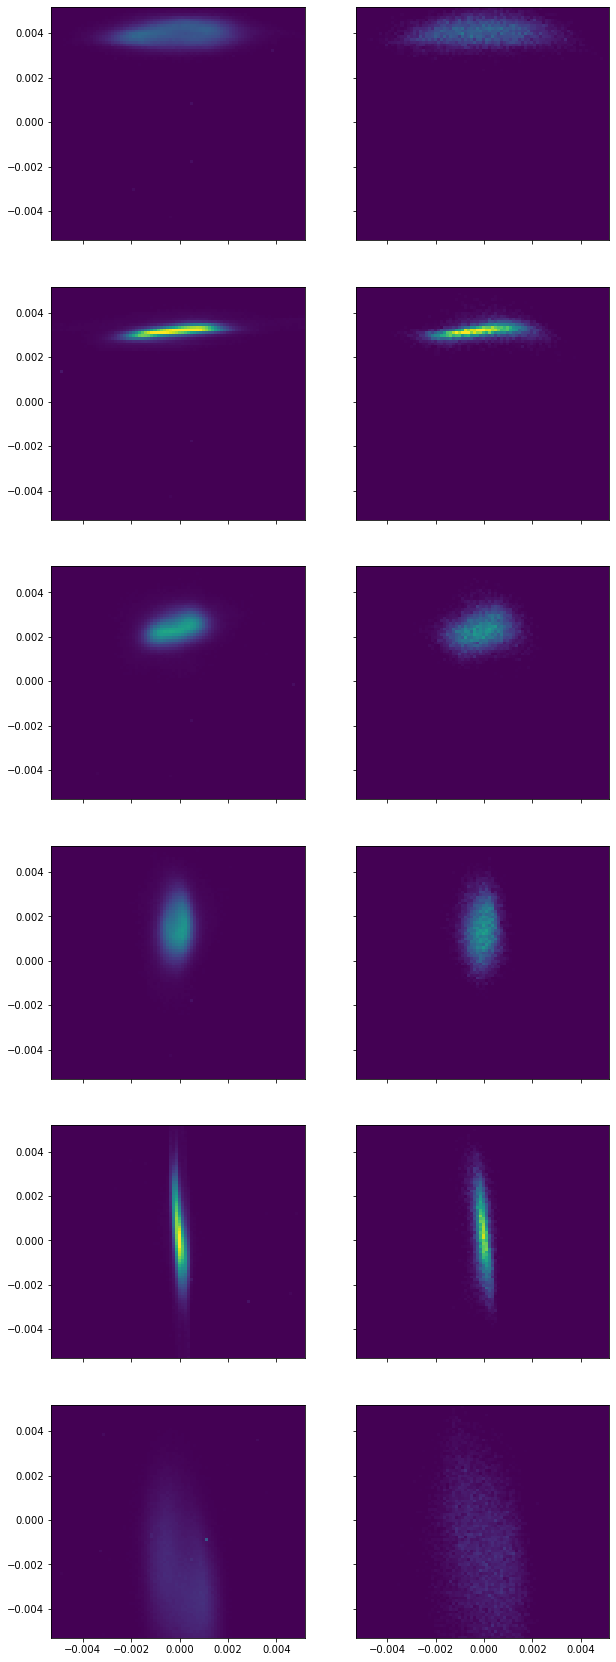

In [2]:
s = torch.arange(0,11,2)
with torch.no_grad():
    predictions, entropy = ensemble[0](train_dset[s][0].cuda())

fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(s)):
    ax[i][0].pcolor(*xx, train_dset[s[i]][1][0].cpu().detach(),
                    vmin=0,vmax=0.01
                    )
    ax[i][1].pcolor(*xx,predictions[i][0].cpu().detach(), vmin=0,vmax=0.01)

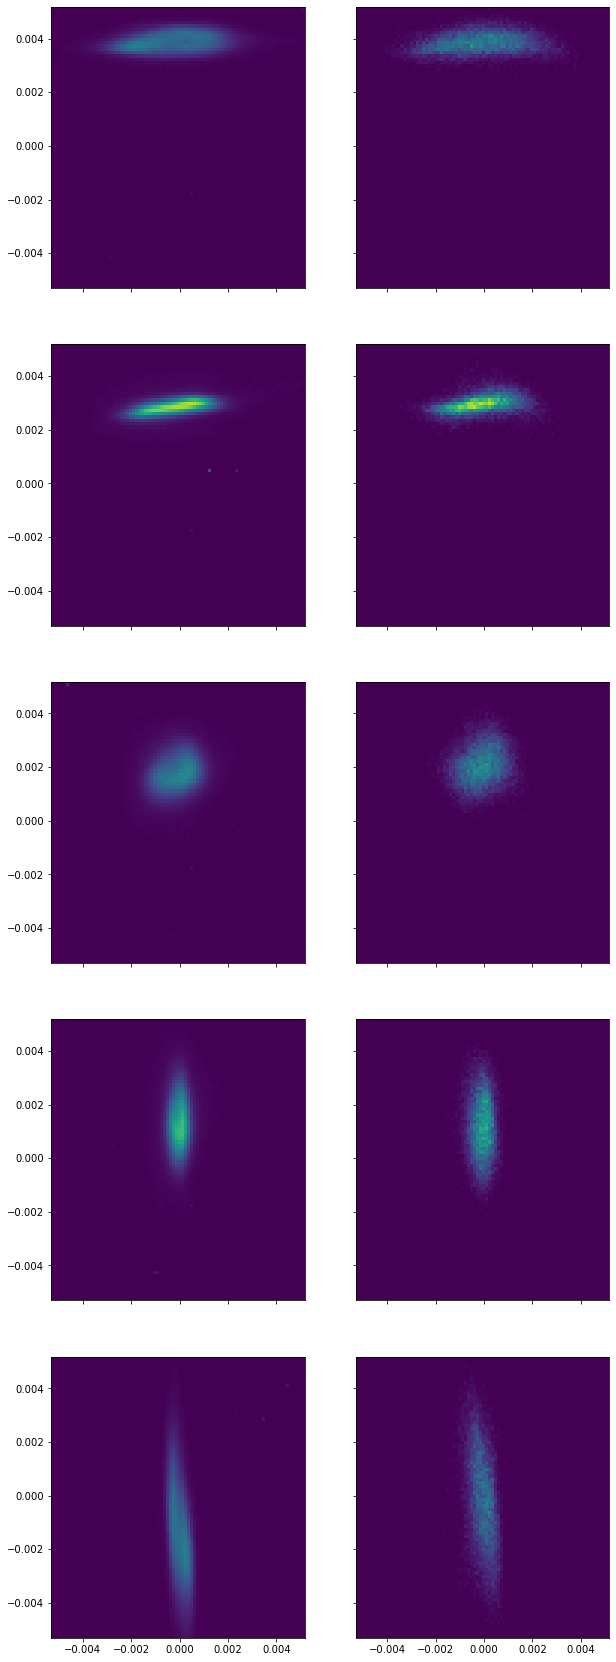

In [3]:
s = torch.arange(0,10,2)
with torch.no_grad():
    predictions, entropy = ensemble[0](test_dset[s][0].cuda())

fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(s)):
    ax[i][0].pcolor(*xx,test_dset[s[i]][1][0].cpu().detach(),
                    vmin=0,vmax=0.01
                    )
    ax[i][1].pcolor(*xx,predictions[i][0].cpu().detach(), vmin=0,vmax=0.01)

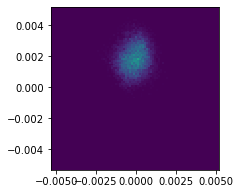

In [4]:
# zero quad strength
with torch.no_grad():
    predictions, entropy = ensemble[0](torch.zeros(1,1).cuda())

fig,ax = plt.subplots()
fig.set_size_inches(3,3)
ax.pcolor(*xx,predictions[0].cpu().detach(), vmin=0,vmax=0.01)


In [5]:
# plot loss record
loss = torch.stack(torch.load(save_dir + "/loss_log.pt"))

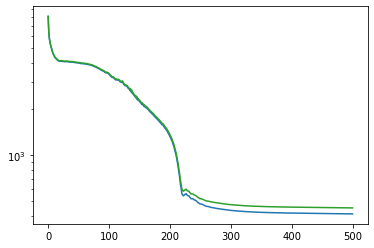

In [6]:
plt.semilogy(loss)

In [7]:
initial_beam = ensemble[0].beam()

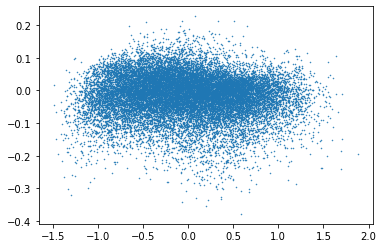

In [8]:
# propagate particles w/quad off
initial_y = initial_beam.y.cpu().detach().numpy()*1e3
initial_py = initial_beam.py.cpu().detach().numpy()*1e3

# distances
dist_to_slits = 3.38 - 2.84 + 0.12/2.0
dist_to_screen = 3.38 + 0.12/2.0

# particles
slits_y = initial_y + initial_py * dist_to_slits
slits_py = initial_py

screen_y = initial_y + initial_py * dist_to_screen
screen_py = initial_py

fig,ax=plt.subplots()
ax.plot(
    initial_y,
    initial_py,
    '.',ms=1
)

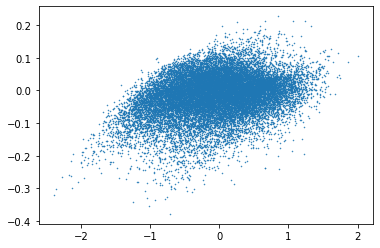

In [9]:
fig,ax=plt.subplots()
ax.plot(
    screen_y, screen_py,
    '.',ms=1
)

Text(0.5, 0, '$y$ (mm)')

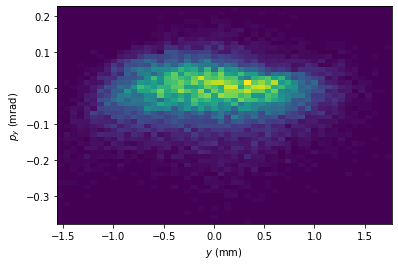

In [10]:
fig,ax=plt.subplots()
ax.hist2d(
    slits_y,
    slits_py, bins=50
);
ax.set_ylabel(r"$p_y$ (mrad)")
ax.set_xlabel(r"$y$ (mm)")

Text(0.5, 0, '$y$ (mm)')

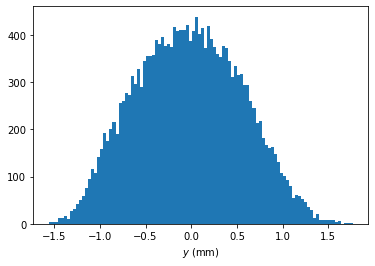

In [11]:
fig,ax=plt.subplots()
ax.hist(
    slits_y, bins=100
);
ax.set_xlabel(r"$y$ (mm)")

Text(0.5, 0, '$yp$ (mrad)')

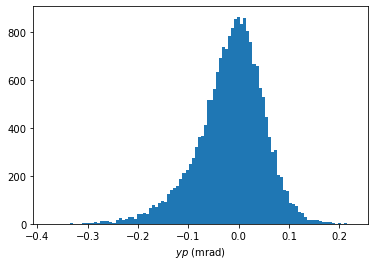

In [12]:
fig,ax=plt.subplots()
ax.hist(
    slits_py, bins=100
);
ax.set_xlabel(r"$yp$ (mrad)")

In [13]:
cov = torch.cov(initial_beam.data.T)
cov

tensor([[ 3.8461e-07,  1.8503e-08,  6.7885e-08, -1.6283e-08, -3.3780e-07,
         -4.8738e-07],
        [ 1.8503e-08,  7.2029e-09,  1.6248e-08, -7.9210e-10,  2.8104e-08,
          2.1156e-08],
        [ 6.7885e-08,  1.6248e-08,  3.3081e-07, -2.2004e-09,  4.7905e-08,
          4.2044e-07],
        [-1.6283e-08, -7.9210e-10, -2.2004e-09,  4.4084e-09,  2.4393e-08,
          4.3644e-08],
        [-3.3780e-07,  2.8104e-08,  4.7905e-08,  2.4393e-08,  3.5319e-06,
          1.4354e-06],
        [-4.8738e-07,  2.1156e-08,  4.2044e-07,  4.3644e-08,  1.4354e-06,
          2.5570e-06]], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [14]:
ycov = cov[2:4,2:4]

In [15]:
ycov

tensor([[ 3.3081e-07, -2.2004e-09],
        [-2.2004e-09,  4.4084e-09]], device='cuda:0', grad_fn=<SliceBackward0>)

In [16]:
emit = torch.det(ycov).sqrt()
twiss = ycov / emit
print(f"emit {emit}")
print(f"beta {twiss[0,0]}")
print(f"alpha {-twiss[1,0]}")
print(f"gamma {twiss[1,1]}")

emit 3.8125026691204766e-08
beta 8.677041053771973
alpha 0.05771556496620178
gamma 0.11563054472208023


In [17]:
# geometric emittance
print(f"geo_emit: {emit}")
print(f"norm emit: {emit*63.0/0.511}")

geo_emit: 3.8125026691204766e-08
norm emit: 4.700345925812144e-06
